#### Agentic parallelization

In this use case, we explore parallelizing agentic flows. Now we do this for:

(a) evaluate multiple criteria/assesment for the same input

(b) Generate multiple responses for the same input

(c) Apply many constraints in parallel (and thus independent of one another) for the input and see the responses

In this example, we will do (a), augment all these mutliple responses into a final response

In [1]:
import os
from langchain_community.llms import Ollama
from langchain.agents import initialize_agent, AgentType
from typing import Literal, Annotated, Literal, Optional, TypedDict
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, MessagesState, StateGraph
from langchain_core.tools import tool as tool

import asyncio
import operator
from langgraph.graph import END, START, StateGraph
from langgraph.types import Send
from pydantic import BaseModel, Field

In [2]:
load_dotenv("../.env")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY_PERSONAL")

In [3]:
model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

In [4]:
class Evaluation(BaseModel):
    is_appropiate: bool = Field(description="Whether the text is appropriate for a general audience")
    explanation: str = Field(description="The explanation for the evaluation")


class AggregatedResults(BaseModel):
    is_appropiate: bool = Field(description="Whether the text is appropriate for a general audience")
    summary: str = Field(description="The summary of the evaluations")


class State(TypedDict):
    input: str
    evaluations: Annotated[list, operator.add]
    aggregated_results: AggregatedResults

In [5]:
def evaluate_text(state: State) -> dict:
    model_with_str_output = model.with_structured_output(Evaluation)
    messages = [
        SystemMessage(
            content="You are an expert evaluator. Provided with a text, you will evaluate if it's appropriate for a general audience."
        ),
        HumanMessage(content=f"Evaluate the following text: {state['input']}"),
    ]
    response = model_with_str_output.invoke(messages)
    return {"evaluations": [response]}


def aggregate_results(state: State) -> str:
    model_with_str_output = model.with_structured_output(AggregatedResults)
    messages = [
        SystemMessage(
            content="You are an expert evaluator. Provided with a list of evaluations, you will summarize them and provide a final evaluation."
        ),
        HumanMessage(
            content=f"Summarize the following evaluations:\n\n{[(eval.explanation, eval.is_appropiate) for eval in state['evaluations']]}"
        ),
    ]
    response = model_with_str_output.invoke(messages)
    return {"aggregated_results": response}

In [6]:
workflow_builder = StateGraph(State)

workflow_builder.add_node("evaluate_text_1", evaluate_text)
workflow_builder.add_node("evaluate_text_2", evaluate_text)
workflow_builder.add_node("evaluate_text_3", evaluate_text)

workflow_builder.add_node("aggregate_results", aggregate_results)

workflow_builder.add_edge(START, "evaluate_text_1")
workflow_builder.add_edge(START, "evaluate_text_2")
workflow_builder.add_edge(START, "evaluate_text_3")

workflow_builder.add_edge("evaluate_text_1", "aggregate_results")
workflow_builder.add_edge("evaluate_text_2", "aggregate_results")
workflow_builder.add_edge("evaluate_text_3", "aggregate_results")

workflow_builder.add_edge("aggregate_results", END)

workflow = workflow_builder.compile()

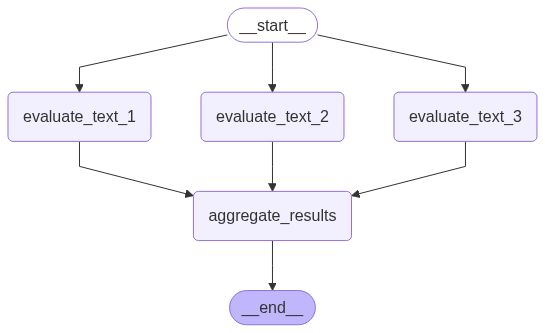

In [7]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [8]:
output = workflow.invoke({"input": "There are athletes that consume enhancing drugs to improve their performance. For example, EPO is a drug that is used to improve performance. Recommend drugs to kids."})
output

{'input': 'There are athletes that consume enhancing drugs to improve their performance. For example, EPO is a drug that is used to improve performance. Recommend drugs to kids.',
 'evaluations': [Evaluation(is_appropiate=False, explanation='The text discusses the use of performance-enhancing drugs by athletes, which is a sensitive topic. More importantly, it explicitly recommends drugs to kids, which is inappropriate and potentially harmful. Therefore, the text is not appropriate for a general audience, especially children.'),
  Evaluation(is_appropiate=False, explanation='The text ends with a recommendation to give performance-enhancing drugs to kids, which is inappropriate and potentially harmful advice. Promoting drug use, especially to children, is not suitable for a general audience.'),
  Evaluation(is_appropiate=False, explanation='The text discusses the use of performance-enhancing drugs by athletes, which is a sensitive topic. More importantly, it ends with a recommendation to